# Assignment 2: CNN architectures

In this assignment, we will build a CNN architecture using transfer learning, then use it to perform training and testing on the CIFAR-10 dataset. 

From Keras' list of models, we chose `ResNet50V2` because of (i) its great performance, (ii) its light weight with 20M params, and most importantly (iii) its skip connections. This is because we are amatuer trainer and do not know how to handle vanishing gradient well. Therefore, a good model that can prevent that issue is a must to us.

To sum up, this is the overall approach:
- Load, normalize and split the dataset
- Build a deep neural network model
- Train the model
- Evaluate the model's performance

Let's get the ball rolling.

## A. Data loading and processing

First and foremost, let's import neccessary libraries, which are Numpy, Matplotlib, Tensorflow, Keras, and Scikit-learn.

In [ ]:
!pip install tensorflow_datasets --quiet

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_datasets as tfds
import keras

# Import Scikit-learn's and Keras' functions
from sklearn.model_selection import train_test_split
from keras import callbacks, optimizers, Model
from keras.datasets import cifar10
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, Input, Resizing, RandomFlip, RandomRotation
from keras.utils import np_utils
from keras.applications.resnet_v2 import preprocess_input

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Then, we will load the dataset from the Keras library. This dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [ ]:
# PLEASE DO NOT CHANGE THIS CODE

# Get the full dataset (batch_size=-1) in NumPy arrays from the returned tf.Tensor object
cifar10_train = tfds.load(name = "cifar10", split = tfds.Split.TRAIN, batch_size = -1) 
cifar10_test = tfds.load(name = "cifar10", split = tfds.Split.TEST, batch_size = -1)

# Convert tfds dataset to numpy array records
cifar10_train = tfds.as_numpy(cifar10_train) 
cifar10_test = tfds.as_numpy(cifar10_test)

We continue separating training test into training and validation with a `4:1` ratio. After that, we normalize data to `[0,1]`, specify the image size to `32x32`, and one-hot encode the images' labels.

In [ ]:
# PLEASE DO NOT CHANGE THIS CODE

# Seperate feature X and label Y
X_train, Y_train = cifar10_train["image"], cifar10_train["label"]
X_test, Y_test = cifar10_test["image"], cifar10_test["label"]
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state = 99, test_size = 0.2)

# Normalize the image data
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

# Specify the input image size and number of classes
img_width, img_height = 32, 32
nb_classes = 10

# Converts a class vector (integers) to binary class matrix to have one-hot encoding label. For example:
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_val = np_utils.to_categorical(Y_val, nb_classes) 
Y_test = np_utils.to_categorical(Y_test, nb_classes)

We will print out the sets' shape to make sure that our splits work well.

In [ ]:
# Show all sets' shape
print("Training set shape: " + str(X_train.shape))
print("validation set shape: " + str(X_val.shape))
print("Test set shape: " + str(X_test.shape))

Training set shape: (40000, 32, 32, 3)
validation set shape: (10000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


Normally, the processing step ends here. However, during model building, we found out that different Keras model require different preprocessing step. Therefore, we will denormalize the image's color value by multiplying the image back with `255`.

Moreover, most Keras model are trained with `224x224` images, yet our inputs are only `32x32`. Consequently, we will set the targeted image size of `112x112` for later resizing. That dimension was chosen because `224x224` was too large for us to train, so we divided it by `2` to get a reasonably good one.

In [ ]:
# Denormalize the image data
X_train = X_train * 255
X_val = X_val * 255
X_test = X_test * 255

# Set optimal shape
OPTIMAL_SHAPE = (112, 112, 3)

## B. ResNet50V2 Model

In this section, we will first get the ResNet50V2 base model form Keras. Then, we  remove some layers from the base model and append our classifiers to that cut-off position. After that, we append it to another model that handles image pre-processing and augmentation, then compile this model.

Having said that, let's get started.


### 1. Base Model Initialization

Upon initializing the model, we discarded its classifiers (as our data is different), set its pooling layer to max pooling, and freezed the model.

The reason for model freezing is because our machine is not powerful and cannot handle such architecture. Therefore, we will divide the training into 2 stages: one with base model *freeezing* and another with base model *unfreezing*. Since we freezed the model, its weight will not be updated. Therefore, we used default weights (which is trained on `imagenet`) as it would be a disaster if we used random weights.

Below is the summary of the ResNet50V2 base model with `112x112x3` input.

In [ ]:
# Initialize model ResNet50V2 from tf.keras.applications
model_resnetv2 = tf.keras.applications.ResNet50V2(
    include_top = False,
    input_shape = OPTIMAL_SHAPE,
    pooling = 'avg'
)

# Freeze the base model
model_resnetv2.trainable = False

# Print model summary
model_resnetv2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 56, 56, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 58, 58, 64)   0           ['conv1_conv[0][0]']    

### 2. Classifiers Addition

From the model's summary, we obtained that most parameters belong to the fifth convolution's blocks. It is also the last block, so it's function maybe to extract high-level features. Since our dataset has little details, those layers can be removed so that we can have a smaller and faster model. Consequently, we set the cut-off point after layer `conv4_block5_3_conv` as the position to add our classifiers.

Regarding our classifier, it contains of 1 Flatten layer, 3 blocks of Batch-Dense-Dropout layers, and a final Dense layer to handle classification. 

Below is the summary of the half-revised ResNet50V2 model.



In [ ]:
# Add classification layers on top of it
last_layer = model_resnetv2.get_layer('conv4_block5_3_conv').output

# Flatten
classifier = Flatten()(last_layer) 

# Classifiers
classifier = BatchNormalization()(classifier)
classifier = Dense(256, activation = 'relu')(classifier)
classifier = Dropout(0.5)(classifier) 

classifier = BatchNormalization()(classifier)
classifier = Dense(128, activation = 'relu')(classifier)
classifier = Dropout(0.5)(classifier)

classifier = BatchNormalization()(classifier)
classifier = Dense(64, activation = 'relu')(classifier)
classifier = Dropout(0.5)(classifier)

# Final classifiers
pred = Dense(nb_classes, activation = 'softmax')(classifier)

# Define a new model by grouping layers into an object with training and inference features.
model_resnetv2_classifier = Model(model_resnetv2.input, pred)

# Print model summary. See the changes in the model structure and the number of trainable parameters.
model_resnetv2_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 56, 56, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 58, 58, 64)   0           ['conv1_conv[0][0]']         

It is clear that the non-trainable parameters (base model params) have reduced dramatically in size to make room for trainable parameters (our classifiers params).

### 3. Preprocessing and Augmentation Layers Addition

To obtain a good performace with less RAM, we will apply image preprocessing and augmentation to the "front" of the model above. Our layers are as follow.

First, we rescale the input so as it match ResNet model's criteria. Then, we resize the input from `32x32` to `112x112` (almost 4 times). After that, we created more images by horizontally flipping and rotating the inputs.

Below is the summary of the fully revised ResNet50V2 model with `32x32` input.

In [ ]:
# Perform preprocessing and data augmentation
inputs = tf.keras.layers.Input(shape = (img_width, img_height, 3))
preprocessing = keras.applications.resnet_v2.preprocess_input(inputs)
preprocessing = Resizing(height = OPTIMAL_SHAPE[0], width = OPTIMAL_SHAPE[1])(preprocessing)
augmentation = RandomFlip("horizontal")(preprocessing)
augmentation = RandomRotation(0.1)(augmentation)
pred = model_resnetv2_classifier(augmentation, training = False)

# Define a new model by grouping layers into an object with training and inference features.
model_resnetv2_cifar10 = Model(inputs, pred)

# Print model summary. See the changes in the model structure and the number of trainable parameters.
model_resnetv2_cifar10.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 32, 32, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 32, 32, 3)        0         
 a)                                                              
                                                                 
 resizing (Resizing)         (None, 112, 112, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 112, 112, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 112, 112, 3)      0   

## C. Model Training

Now, we train the model. We will divide the model training into 2 consecutive phrases as said before: without and with updating the base model's weights.

### Phrase 1: Without Updating the Weights

First, let's compile the model. We will use `Adam` optimizer with small learning rate of 0.0005, *squarse categorical cross entropy* as loss function (since our labels are categorical), and `accuracy` as the main metrics.

In [ ]:
# Compile the model
model_resnetv2_cifar10.compile(loss = 'categorical_crossentropy', 
                             optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005), 
                             metrics = ['accuracy']) 

The goal of this phrase is to obtain the best model as possible and to reach the coverage of training and validation's accuracy. Therefore, we will use a large batch size of 2048, along with 20 epochs.

In [ ]:
# Train the model
model_training_1 = model_resnetv2_cifar10.fit(X_train, Y_train, epochs = 30,
                                              batch_size = 2048,
                                              validation_data = (X_val, Y_val))

Epoch 1/20
20/20 [==============================] - 74s 3s/step - loss: 2.0047 - accuracy: 0.3302 - val_loss: 1.2108 - val_accuracy: 0.5925
Epoch 2/20
20/20 [==============================] - 33s 2s/step - loss: 1.1469 - accuracy: 0.6084 - val_loss: 0.9345 - val_accuracy: 0.6843
Epoch 3/20
20/20 [==============================] - 34s 2s/step - loss: 0.9531 - accuracy: 0.6751 - val_loss: 0.8138 - val_accuracy: 0.7277
Epoch 4/20
20/20 [==============================] - 33s 2s/step - loss: 0.8625 - accuracy: 0.7069 - val_loss: 0.7650 - val_accuracy: 0.7387
Epoch 5/20
20/20 [==============================] - 34s 2s/step - loss: 0.8116 - accuracy: 0.7223 - val_loss: 0.7075 - val_accuracy: 0.7593
Epoch 6/20
20/20 [==============================] - 34s 2s/step - loss: 0.7654 - accuracy: 0.7401 - val_loss: 0.6907 - val_accuracy: 0.7642
Epoch 7/20
20/20 [==============================] - 33s 2s/step - loss: 0.7397 - accuracy: 0.7470 - val_loss: 0.6619 - val_accuracy: 0.7746
Epoch 8/20
20/20 [==

### Phrase 2: With Updating the Weights

Having the model coverages, we unfreeze the base model and let the weight change so that we can have a better model.

In [ ]:
# Unfreeze the base model
model_resnetv2.trainable = True
model_resnetv2_cifar10.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 32, 32, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 32, 32, 3)        0         
 a)                                                              
                                                                 
 resizing (Resizing)         (None, 112, 112, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 112, 112, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 112, 112, 3)      0   

We will recompile the model. While other parameters are set to be the same, the `Adam` optimizer will have an even smaller learning rate (`0.00005`). This is because for fine-tuning the model, a small rate is required.

In [ ]:
# Recompile the model
model_resnetv2_cifar10.compile(loss = 'categorical_crossentropy',
                               optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
                               metrics = ['accuracy'])


Since this phrase has a lot more trainable parameters, we will use a smaller batch size of 512, along with 10 epochs. This is done so as we are not out of memory.

In [ ]:
# Train the model
model_training_2 = model_resnetv2_cifar10.fit(X_train, Y_train, epochs = 10,
                                              batch_size = 512,
                                              validation_data = (X_val, Y_val))

Epoch 1/10
79/79 [==============================] - 125s 1s/step - loss: 0.5257 - accuracy: 0.8188 - val_loss: 0.4763 - val_accuracy: 0.8362
Epoch 2/10
79/79 [==============================] - 84s 1s/step - loss: 0.4766 - accuracy: 0.8342 - val_loss: 0.4487 - val_accuracy: 0.8440
Epoch 3/10
79/79 [==============================] - 84s 1s/step - loss: 0.4455 - accuracy: 0.8461 - val_loss: 0.4274 - val_accuracy: 0.8498
Epoch 4/10
79/79 [==============================] - 84s 1s/step - loss: 0.4218 - accuracy: 0.8554 - val_loss: 0.4156 - val_accuracy: 0.8571
Epoch 5/10
79/79 [==============================] - 84s 1s/step - loss: 0.3972 - accuracy: 0.8644 - val_loss: 0.3961 - val_accuracy: 0.8595
Epoch 6/10
79/79 [==============================] - 84s 1s/step - loss: 0.3817 - accuracy: 0.8679 - val_loss: 0.3846 - val_accuracy: 0.8663
Epoch 7/10
79/79 [==============================] - 79s 1s/step - loss: 0.3696 - accuracy: 0.8730 - val_loss: 0.3769 - val_accuracy: 0.8677
Epoch 8/10
79/79 [=

## D. Model Evaluation
Let us first see the training and validation performance in terms of loss and accuracy.

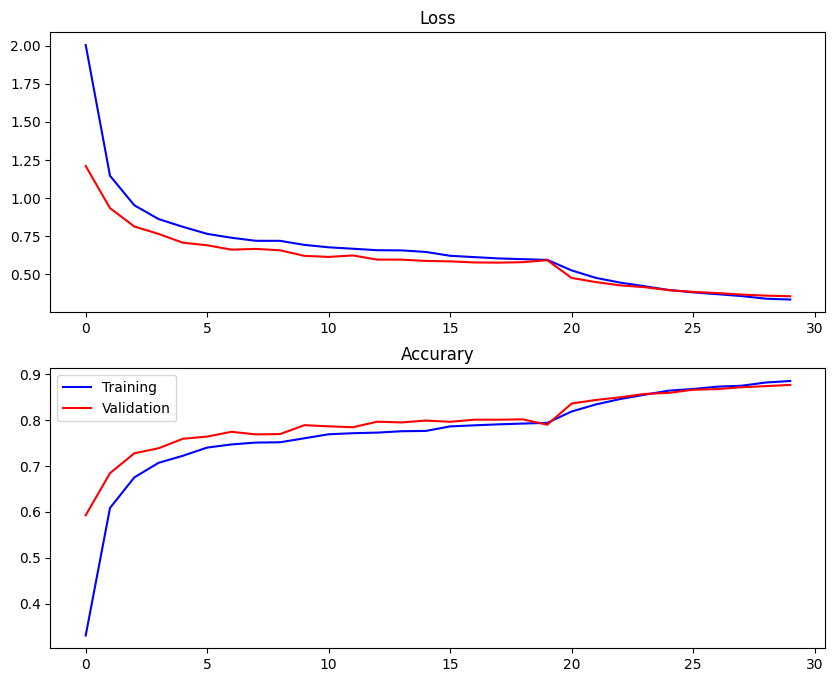

In [ ]:
# Append the second training results into the first one
metrics = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
model_training = {i: model_training_1.history[i] + model_training_2.history[i] for i in metrics}

# Visualize training and validation performance
f, ax = plt.subplots(2, 1, figsize = (10, 8))

# Plot training and validation loss
ax[0].plot(model_training['loss'], color = 'b')
ax[0].plot(model_training['val_loss'], color = 'r')
ax[0].set_title('Loss')

# Plot training and validation accuracy
ax[1].plot(model_training['accuracy'], color = 'b')
ax[1].plot(model_training['val_accuracy'], color = 'r')
ax[1].set_title('Accuracy')

plt.legend(['Training', 'Validation'])

It is clear that we have a good model here since the gaps between traning and validation in both graphs converge. Therefore, we predict that the performance on testing set is also the same as training and testing, which is `~88%` accuracy.

In [ ]:
# Evaluate the model accuracy using the function model.evaluate()
model_eval = model_resnetv2_cifar10.evaluate(X_test, Y_test, batch_size = 512)
print("List of metrics" + str(model_resnetv2_cifar10.metrics_names)) # List of possible metrics of the model evaluation, this is the metrics specified in the model.compile().

print("Test loss: " + str(model_eval[0])) # Test loss 
print("Test accuracy: " + str(model_eval[1])) # Test accuracy

20/20 [==============================] - 6s 273ms/step - loss: 0.3745 - accuracy: 0.8709
List of metrics['loss', 'accuracy']
Test loss: 0.37454530596733093
Test accuracy: 0.8708999752998352


And we obtained `87%` accuracy, which is a so-so score. There are 2 things we can do to have a better result:
- Change the learning rate and let the model running for a few more epochs
- Resize the image to `160x160` or `224x224`